# Question 1

I’ve marked the most recent ancestor with snakes in green and the most recent ancestor with birds in blue. We can see that, according to the morphological and microRNA evidence, turtles are most closely related to snakes. However, according to the mtDNA and nucDNA evidence, they are more closely related to birds. Here, “more closely related” means their lines diverged more recently.

![](2022-01-13-18-55-58.png)

# Question 2

Humans were an appropriate choice of outgroup for an analysis of birds and turtles because the most recent common ancestor of humans and any bird or reptile is older than the most recent common ancestor between any two organisms from that group. Any mammal would work here, for example, dogs. Crocodiles would be an inappropriate choice because, as shown in the trees above, crocodiles diverged more recently from birds than they did from reptiles.

# Question 3

My guess is that the root was either green or red. There was an initial split where the other color occurred, and that is the earliest split in to evolutionary tree. Then, on the left branch, red and black both emerged independently a few times (an example of homoplasy). On the right side, blue and green both emerged from the red as number of times as well.

Since most of the history of the right branch is unknown, other theories are possible. It would be that the right branch was blue or green and red emerged twice independently on the right branch. If the right branch was initially blue, that would explain why it can be found in two of the subbranches of the right branch: the subbranches containing SUNT and CREN. It seems unlikely that the right branch was black, because this color never appears among lines with known character there.

More broadly, this visualization seems to support the idea that phylogeny and chemical composition are related. However, it seems relatively easy for lines to change chemical composition to fit the needs of the environment.


# Question 4

For this question, we need to find branches that start in India, then move to Sri Lanka, then come back to India. The only phylogeny with well-documented evidence for a single migration of this kind is the crab in figure F. The lines leading from the root to the clade with the families *spiralothelphusa wuellerstorfi*, *spiralothelphusa sp 1*, *oziotelphusa sp 7*, *oziotelphusa sp 6*, *oziotelphusa sp 5* is first brown, then green, then brown. The phylogenic process here is extremely confident; bootstrapping assigns probabilities of 94%+ to every clade containing this one. So, as long as we are confident about the geographic information assigned to ancestor species, then we should be confident that a migration occured.

The fish (figure d) also show evidence of migration, but it is clear that there must have been at least two separate migrations.

# Question 5

In [210]:
bugs = {
    "Escherichia coli": "AACGTTCTAGGCCCATACGG",
    "Bacillus anthracis": "AACGTTCTAGGGCCATACGG",
    "Synechococcus": "AACGTCGTAGGACCATCCGG",
    "Chlorobium": "AACGTCATAGGACCATGCGG",
    "Methanococcus": "ATCGTATAACGTCGATTCGG",
}

def dist(a, b):
    """Simple similarity score between two strings: the portion of characters which are the same"""
    assert len(a) == len(b)
    return sum(x == y for x, y in zip(a, b))/len(a)

print("Distance Matrix\n" + ("-" * 59))
for i, bug in enumerate(bugs):
    distances = [f"{bug:16}"] + ["----" for _ in range(i + 1)]
    for other_bug in list(bugs)[i + 1:]:
        distances.append(dist(bugs[bug], bugs[other_bug]))
    print("\t".join(str(s) for s in distances))


Distance Matrix
-----------------------------------------------------------
Escherichia coli	----	0.95	0.8	0.8	0.6
Bacillus anthracis	----	----	0.8	0.8	0.6
Synechococcus   	----	----	----	0.9	0.6
Chlorobium      	----	----	----	----	0.6
Methanococcus   	----	----	----	----	----


One way to create a phylogeny is iteratively, based on the distances between sequences. At each step, the nearest two sequences or clades are joined into a new clade until there is only one clade.

I implement this using the `networkx` library. Each of the sequences is added as a node to an undirected, weighted, complete graph called the `distance graph`. The weight $w_{ij}$ between each two nodes $i$ and $j$ in the graph is initialized to the distances between the sequences $i$ and $j$. Another weighted, directed graph called the `tree` is initialized empty.

At each step, the algorithm finds the two closest nodes $a$ and $b$ in the `distance graph`. It creates a new node $u$ representing a clade containing these two nodes. It adds $u$ to the distance graph. For each other node $k$ in the distance graph, it sets the weight $w_{ku}$ of the edge from $k$ to $u$ equal to the average of the weights $w_{ak}$ and $w_{bk}$.

Then, it removes $a$ and $b$ from the `distance graph`. The new clade $u$, $a$, and $b$ are then all added to the `tree`. Directed edges are added from $u$ to $a$ and $b$. The weights of these edges are equal and sum to the distance between the sequences $a$ and $b$.

At the end of the process, the `tree` and the most recently created clade $u$ (which is the root clade) are returned.

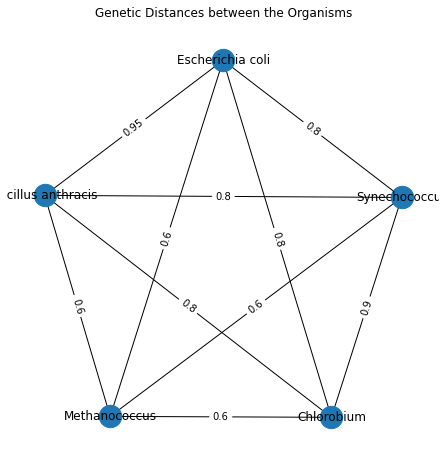

In [211]:
import networkx as nx
from itertools import combinations, count
import matplotlib.pyplot as plt

# computes distances between each pair of sequences
distance_graph = nx.Graph()
for a, b in combinations(bugs, 2):
    distance_graph.add_edge(a, b, dist=dist(bugs[a], bugs[b]))

# plots the graph
plt.figure(figsize=(6, 6))
layout = nx.spring_layout(distance_graph)
nx.draw(distance_graph, layout, with_labels=True, node_size=500)
nx.draw_networkx_edge_labels(distance_graph, layout, edge_labels=nx.get_edge_attributes(distance_graph, "dist"))
plt.title("Genetic Distances between the Organisms")
plt.show()

In [212]:
def draw_tree(tree, root, w=1, h=-1, kill_nums=True):
    """Draws a networkx directed graph as a tree based a root
    
    Labels every node whose name is a string (as opposed to a number)
    """
    stack = [root]
    layout = {root: (w, h)}
    while stack:
        node = stack.pop()
        x, y = layout[node]
        for i, child in enumerate(tree.successors(node)):
            stack.append(child)
            layout[child] = (x + w, y + (i - 0.5)*h)
    
    # only display node name if its a word
    if kill_nums:
        labels_to_use = {}
        for node in tree:
            try:
                float(node)
            except ValueError:
                labels_to_use[node] = node

    plt.figure(figsize=(8, 6))
    nx.draw(tree, layout, node_size=0)
    nx.draw_networkx_labels(tree, layout, labels=labels_to_use)
    nx.draw_networkx_edge_labels(tree, layout, edge_labels=nx.get_edge_attributes(tree, 'dist'))

In [213]:
def tree_from_distances(distance_graph):
    """Builds a phylogeny from the distance graph, returning the tree and the name of the root"""
    distances = distance_graph.copy()
    tree = nx.DiGraph()
    i = count()

    # move nodes from the distance matrix 
    while len(distances.nodes) > 1:

        # find the closest pair of nodes
        a, b, d_ab = min(distances.edges.data('dist'), key=lambda x: x[2])
        
        # combine the two nodes into a new clade
        new = next(i)
        tree.add_node(new)
        tree.add_edge(new, a, dist=d_ab/2)
        tree.add_edge(new, b, dist=d_ab/2)

        # compute distances from this clade to each other node
        for node in distances.nodes - {a, b}:
            avg_dist = (distances[a][node]['dist'] + distances[b][node]['dist'])/2
            distances.add_edge(new, node, dist=avg_dist)
        
        # remove the old nodes from the distance graph
        distances.remove_nodes_from({a, b})
    root = new

    return tree, root

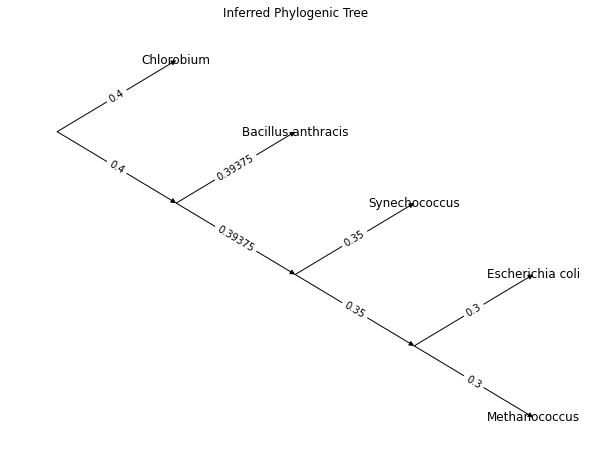

In [214]:
draw_tree(*tree_from_distances(distance_graph))
plt.title("Inferred Phylogenic Tree")
plt.show()

# Question 6

I ran a BLAST search using the sequence of the new strain. Then, I sorted by the percentage similar among results and took the top ten. All of these were influenza strains. Since these are the closest existing strains to the new one, we can make a guess that they are phylogenetically related.

The fasta sequences for the new strain and the comparison strains are stored in `sequences/seqdump.txt`. The first step is to align these sequences. I do this using `muscle`, which is a fast c++ program for multiple sequence alignment. The results are stored in `sequences/seqdump.sln`.

In [215]:
!muscle -align sequences/seqdump.txt -output sequences/seqdump.aln


muscle 5.1.osx64 [ddb630]  8.6Gb RAM, 8 cores
Built Jan 13 2022 23:38:35
(C) Copyright 2004-2021 Robert C. Edgar.
https://drive5.com

Input: 11 seqs, avg length 1064, max 1141

00:00 4.2Mb  CPU has 8 cores, running 8 threads
00:04 425Mb   100.0% Calc posteriors
00:05 134Mb   100.0% Consistency (1/2)
00:05 134Mb   100.0% Consistency (2/2)
00:05 135Mb   100.0% UPGMA5           
00:06 72Mb    100.0% Refining


We can load the resulting, aligned, sequences using biopython.

In [216]:
from Bio.SeqIO import parse
from Bio.Align import MultipleSeqAlignment

sequences = parse(open("sequences/seqdump.aln"), "fasta")
alignment = MultipleSeqAlignment(sequences)
print(alignment)

Alignment with 11 rows and 1141 columns
------------------------------CTGAAACTTCCCGG...--- new_strain
TTGAGCTACATTCTATGTCTGGTTTTCGCTCAAAAACTTCCCGG...C-T EU521884.1
TTGAGCTACATTCTATGTCTGGTTTTCGCTCAAAAACTTCCCGG...CTC EU521885.1
---------ATTCTATGCCTGGTTTTCGCTCAAAAACTTCCCGG...--- EU521779.1
---------------TGTCTGGTTTTCGCTCAAAAACTTCCCGG...--- EU521778.1
---AGCTACATTCTATGTCTGGTTTTCGCTCAAAAACTTCCCGG...--- EU522003.1
---AGCTACATTCTATGTCTGGTTTTCGCTCAAAAACTTCCCGG...--- EU522002.1
------------------------------CTCAAACTTCCCGG...--- EU502102.1
---AGCTACATTCTATGTCTGGTTTTCGCTCAAAAACTTCCCGG...--- EU521782.1
------------------------------CAAAAACTTCCCGG...--- EU502328.1
TTGAGCTACATTCTATGTCTGGTTTTCGCTCAAAAACTTCCCGG...--- EU522015.1


This code uses neighbor joining to build a phylogenetic tree. Neighbor joining is an iterative algorithm that constructs clades by successively joining elements from a pool of organisms and previously formed clades. It is fairly cheap to run, and it is a standard algorithm for tree construction.

In [267]:
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor, ParsimonyScorer, NNITreeSearcher, ParsimonyTreeConstructor

def build_nj(alignment):
    calculator = DistanceCalculator()
    nj_constructor = DistanceTreeConstructor(calculator, "nj")
    return nj_constructor.build_tree(alignment)

nj_tree = build_nj(alignment)

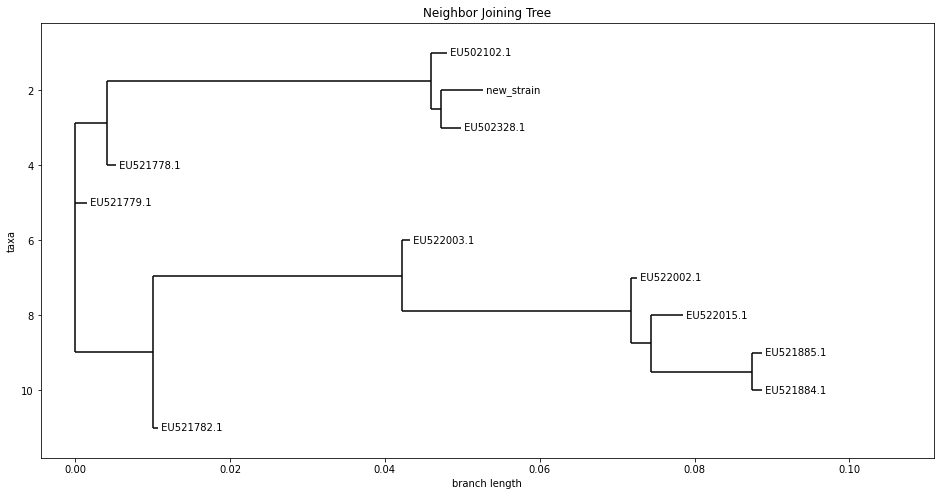

In [268]:
def show_tree(tree, title):
    Phylo.draw(tree, do_show=False, show_confidence=True, label_func=lambda n: n.name if n.is_terminal() else "")
    if title:
        plt.title("Neighbor Joining Tree")
    plt.rcParams["figure.figsize"] = 16, 8
    plt.show()

show_tree(nj_tree, "Neighbor Joining Tree")

In order to bootstrap the tree creation process, we need a way to resample the alignment. This is a way to perturb the alignment in small ways. This allows us to test how robust the final tree is to small changes in the alignment.

We can think about a multi sequence alignment as an $n \times m$ matrix where $n$ is the number of sequences and $m$ is the length of the longest sequence. This resampling process essentially shuffles the columns of this matrix (with replacement). ([source](https://www.pnas.org/content/93/23/13429))

In [269]:
import numpy as np
from Bio.Align import SeqRecord, Seq

def alignment_to_array(alignment):
    return np.array([list(s.seq) for s in alignment])

def array_to_alignment(array, ids=None):
    msa = MultipleSeqAlignment([SeqRecord(Seq("".join(s))) for s in array])
    if ids:
        for r, id in zip(msa, ids):
            r.id = id
    return msa

def resample_alignment(alignment):
    ids = [r.id for r in alignment]
    array = alignment_to_array(alignment)
    seq_len, _ = array.shape
    sample = np.random.choice(seq_len, size=seq_len, replace=True)
    return array_to_alignment(array.T[sample].T, ids)

def lazy_resample(alignment, n_times):
    for _ in range(n_times):
        yield resample_alignment(alignment)

In [261]:
class CladeSearch:
    def __init__(self, tree):
        self.clades = {}
        self.get_clades(tree.root)
    
    def get_clades(self, node):
        if node.is_terminal():
            return frozenset([node.name])
        my_nodes = frozenset().union(*[self.get_clades(c) for c in node.clades])
        self.clades[node.name] = my_nodes
        return my_nodes


def analyze_bootstrap(tree, resampled_trees):
    n_boots = 0
    clades = CladeSearch(tree).clades
    counts = dict.fromkeys(clades, 0)
    for resampled_tree in resampled_trees:
        n_boots += 1
        resampled_clades = set(CladeSearch(resampled_tree).clades.values())
        for clade_name in [node.name for node in tree.get_nonterminals()]:
            if clades[clade_name] in resampled_clades:
                counts[clade_name] += 1
    return {k:v/n_boots for k, v in counts.items()}

In [265]:
from tqdm import tqdm

n_boots = 1000
resampled = tqdm((build_nj(alignment) for alignment in lazy_resample(alignment, n_boots)), total=n_boots)
confidence = analyze_bootstrap(nj_tree, resampled)

for node in nj_tree.get_nonterminals():
    node.confidence = confidence[node.name]

100%|██████████| 1000/1000 [00:11<00:00, 86.79it/s]


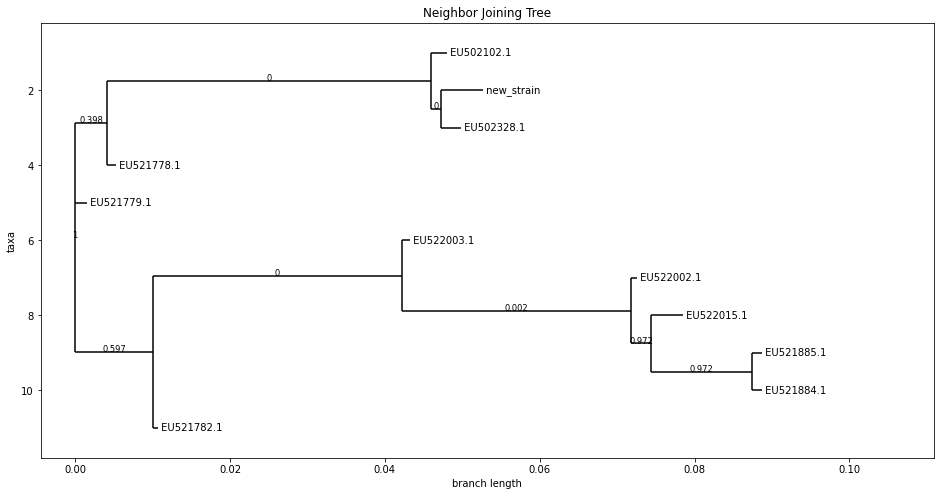

In [266]:
show_tree(nj_tree, "Neighbor Joining Tree with Confidence")

This tree visualization shows the output of the neighbor joining process. We can see that the new strain is a sibling to the EU502328.1 and EU502102.1 strains. This suggests that we should use existing research on these strains to inform research on the new strain, as they may be similar.

For comparison purposes, I next examine a phylogenetic tree generated by a parsimony based approach. Parsimony-based approaches search for the tree which minimizes *parsimony*---the lowest number of evolutionary changes required to explain the tree. This particular approach starts with an initial candidate tree (here, the tree generated by the neighbor joining algorithm) and searches among similar trees for lower parsimony scores.

Parsimony-based approaches are typically reliable, but they can fail to detect homoplasy and often fail when estimating trees with long branch lengths. However, in this example, we are looking at a set of very similar influenza strains, all of which are likely close phylogenetic relatives. So, there are unlikely to be complicated homoplasies which this approach will miss.

The search procedure here works by nearest neighbor interchange. This search procedure generates neighbors to the current tree by looking for intersections where four subtrees meet, such as the subtrees A, B, C, and D in the diagram below.

```
A ---\   /--- C
      ---
B ---/   \--- D

```

It perturbs this intersection by swapping the B subtree with either the C or D subtree. Then, if this new tree has a lower parsimony score, it keeps it. This is an implementation detail that does not encode any assumptions about the shape of the final tree except that it is similar to the initial candidate tree.

In [222]:
scorer = ParsimonyScorer()
searcher = NNITreeSearcher(scorer)
parsimony_builder = ParsimonyTreeConstructor(searcher, nj_tree)
parsimony_tree = parsimony_builder.build_tree(alignment)
Phylo.draw_ascii(parsimony_tree)

                                                                 _ EU521885.1
                                                     ___________|
                                                   _|           |_ EU521884.1
                                                  | |
                        __________________________| |___ EU522015.1
                       |                          |
  _____________________|                          | EU522002.1
 |                     |
 |                     | EU522003.1
 |
 |                   , EU521778.1
_|                   |
 |                ___|                                        ___ new_strain
 |               |   |                                      _|
 |               |   |_____________________________________| |_ EU502328.1
 |       ________|                                         |
 |      |        |                                         |_ EU502102.1
 |______|        |
        |        |_ EU521779.1
        |
        | E

We can see that after the parsimony based search, the new strain is still thought to be siblings with the EU502102.1 and EU502102.1 strains. This should give us confidence that this is the correct subtree.